# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/White_blood_cell_dataset/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:11<00:00, 2798.68it/s]


...metadata prepration ended.
CPU times: user 557 ms, sys: 235 ms, total: 792 ms
Wall time: 12 s


In [6]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

CD14+ monocyte
CD15+ neutrophil
CD19+ B
CD4+ T
CD56+ NK
CD8+ T
NKT
eosinophil


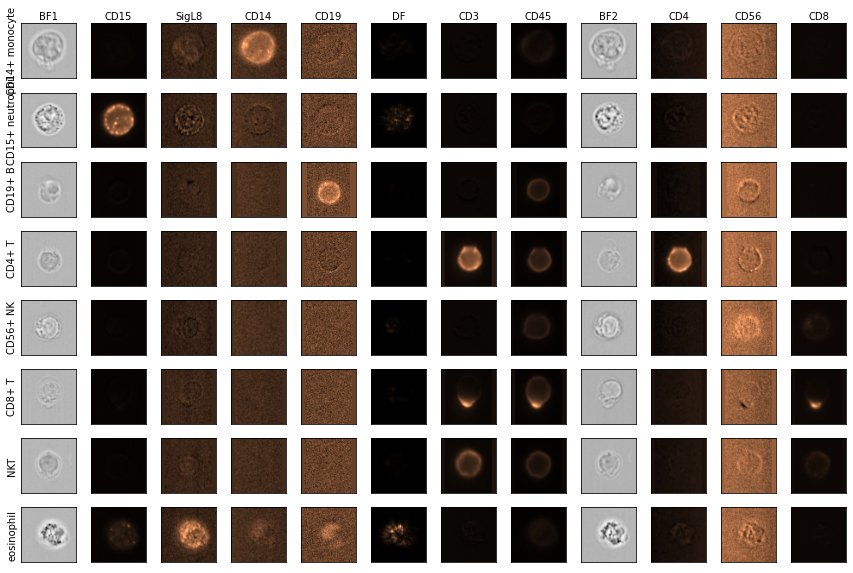

In [7]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (12,8),
                          channels = ["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper","copper", "copper","Greys", "copper", "copper", "copper"],
                    image_size = 64)



plt.savefig("Dataset 3 - white blood cells.png", bbox_inches='tight')
plt.savefig("Dataset 3 - white blood cells.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

In [8]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [11]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 64
num_classes = len(metadata.label.unique())

In [12]:

selected_channels = np.arange(12)
num_channels = len(selected_channels)
channels = np.asarray(["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [13]:
selected_channels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [14]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)
main_fold = 2
i = 1
for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
    if i == main_fold:
        break
    else:
        print(i)
        i+=1


train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)

# train_index =  metadata.set.isin(["train"])
# train_index = train_index[train_index].index

# validation_index =  metadata.set.isin(["validation"])
# validation_index = validation_index[validation_index].index

# test_index =  metadata.set.isin(["test"])
# test_index = test_index[test_index].index

1


In [16]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'CD14+ monocyte': 0,
 'CD15+ neutrophil': 1,
 'CD19+ B': 2,
 'CD4+ T': 3,
 'CD56+ NK': 4,
 'CD8+ T': 5,
 'NKT': 6,
 'eosinophil': 7}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [17]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([]))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

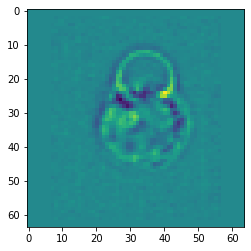

In [19]:
plt.imshow(train_dataset[0][0][0])

In [20]:
def get_statistics(dataloader, selected_channels):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels)
    statistics["p99"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [21]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 150/150 [01:54<00:00,  1.31it/s]

statistics used: {'p01': tensor([2.4857, 0.0420, 0.2060, 0.0667, 0.1020, 0.1333, 0.1364, 0.1176, 2.4004,
        0.1722, 0.0530, 0.1196]), 'p99': tensor([3.7226, 1.9047, 0.2929, 0.1560, 0.1452, 1.6540, 1.1369, 0.6689, 3.6531,
        0.4442, 0.1321, 0.2326])}


adding the normalization to each transform

In [22]:
stats = dict()
stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                     statistics['p01'][1], 
                                     statistics['p01'][2], 
                                     statistics['p01'][3], 
                                     statistics['p01'][4], 
                                     statistics['p01'][5], 
                                     statistics['p01'][6], 
                                     statistics['p01'][7], 
                                     statistics['p01'][8],
                                     statistics['p01'][9], 
                                     statistics['p01'][10], 
                                     statistics['p01'][11]])

stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                     statistics['p99'][1], 
                                     statistics['p99'][2], 
                                     statistics['p99'][3], 
                                     statistics['p99'][4], 
                                     statistics['p99'][5], 
                                     statistics['p99'][6], 
                                     statistics['p99'][7], 
                                     statistics['p99'][8], 
                                     statistics['p99'][9], 
                                     statistics['p99'][10], 
                                     statistics['p99'][11]])

train_transform = [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
]

validation_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

test_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

In [23]:
train_loader = None

defining train, validation and test datasets

In [24]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

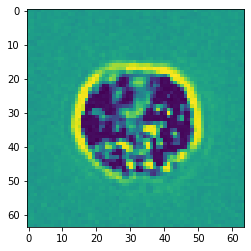

In [25]:
plt.imshow(train_dataset[5][0][0])

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [26]:
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

resnet18_modified = PretrainedModel(num_channels= len(channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [27]:
resnet18_modified

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [28]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                             name =  "valid_f1_micro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

checkpoint = Checkpoint(f_params='white_blood_cells_DL_fold2.pth',
                        monitor='valid_f1_macro_best', load_best=True)

lets define and train the model using `skorch`

In [29]:
net = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
               epoch_scoring_f1_macro, 
               early_stopping, checkpoint],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [30]:
net = net.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp      dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  -------
      1        0.0913       0.8681            0.5935            0.8681        0.5884     +  34.6723
      2        0.0465       0.9948            0.9854            0.9948        0.0287     +  34.6507
      3        0.0324       0.9717            0.9189            0.9717        0.1331        35.3811
      4        0.0319       0.9792            0.9291            0.9792        0.1004        34.8510
      5        0.0286       0.9940            0.9833            0.9940        0.0289        34.8891
      6        0.0252       0.9894            0.9708            0.9894        0.0517        34.8273
      7        0.0210       0.9912            0.9735            0.9912        0.0504        34.9489
      8        0.0210       0.9937            0.9826            0.9937        0.0276        34.7242


     76        0.0034       0.9950            0.9862            0.9950        0.0370        34.8761
     77        0.0042       0.9956            0.9880            0.9956        0.0345        34.6349
     78        0.0026       0.9958            0.9887            0.9958        0.0388     +  34.3941
     79        0.0043       0.9950            0.9860            0.9950        0.0350        34.3823
     80        0.0044       0.9952            0.9866            0.9952        0.0343        34.6408
     81        0.0066       0.9946            0.9860            0.9946        0.0303        34.5752
     82        0.0035       0.9954            0.9873            0.9954        0.0338        34.8060
     83        0.0026       0.9956            0.9871            0.9956        0.0438        34.4233
     84        0.0021       0.9956            0.9880            0.9956        0.0407        34.6684
     85        0.0033       0.9937            0.9831            0.9937        0.0329        34.4681


In [31]:
net.module.load_state_dict(torch.load('white_blood_cells_DL_fold2.pth')) 

<All keys matched successfully>

we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

In [32]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = net.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      1.00       205
CD15+ neutrophil       1.00      1.00      1.00      2932
         CD19+ B       0.99      0.99      0.99       142
          CD4+ T       0.99      1.00      0.99       716
        CD56+ NK       1.00      0.97      0.99       107
          CD8+ T       0.99      0.99      0.99       286
             NKT       0.97      0.93      0.95       165
      eosinophil       1.00      1.00      1.00       246

        accuracy                           1.00      4799
       macro avg       0.99      0.99      0.99      4799
    weighted avg       1.00      1.00      1.00      4799

------------------------------------------------------------
matthews correlation coeff: 0.99
Cohen Kappa score: 0.99
Accuracy: 1.00 & balanced Accuracy: 0.99
macro F1 score: 0.99 & micro F1 score: 1.00
macro Precision score: 0.99 & micro Precision score: 1.00
macro Recall score: 0.99 & micro Recall 

and finally for the test set

In [33]:
y_pred = net.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in y_pred]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      0.99       257
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       1.00      1.00      1.00       178
          CD4+ T       0.99      1.00      0.99       895
        CD56+ NK       0.99      0.98      0.98       134
          CD8+ T       0.97      0.98      0.98       357
             NKT       0.96      0.89      0.93       206
      eosinophil       1.00      1.00      1.00       307

        accuracy                           0.99      5999
       macro avg       0.99      0.98      0.98      5999
    weighted avg       0.99      0.99      0.99      5999

------------------------------------------------------------
matthews correlation coeff: 0.99
Cohen Kappa score: 0.99
Accuracy: 0.99 & balanced Accuracy: 0.98
macro F1 score: 0.98 & micro F1 score: 0.99
macro Precision score: 0.99 & micro Precision score: 0.99
macro Recall score: 0.98 & micro Recall 

In [34]:
performance_with_all_channels = pd.read_csv("performance_with_all_channels.csv")

performance_with_all_channels.loc[main_fold,"accuracy"] = accuracy_score(test_dataset.metadata.label, preds)
performance_with_all_channels.loc[main_fold,"f1_macro"] = f1_score(test_dataset.metadata.label, preds, average="macro")
performance_with_all_channels.loc[main_fold,"f1_micro"] = f1_score(test_dataset.metadata.label, preds, average="micro")

performance_with_all_channels.to_csv("performance_with_all_channels.csv", index = False)

In [35]:
model = net.module_
resnet18_modified = None
net = None
train_dataset = None
torch.cuda.empty_cache()

### Model Interpretation

In [36]:
# where to save results
model_name = "resnet18"
dataset_name = "synapse formation"


#### Pixel-Permutation Tests

In [37]:
from time import process_time

In [38]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [39]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [40]:
class_names_targets = [c for c in label_map.keys()]
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      0.99       257
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       1.00      1.00      1.00       178
          CD4+ T       0.99      1.00      0.99       895
        CD56+ NK       0.99      0.98      0.98       134
          CD8+ T       0.97      0.98      0.98       357
             NKT       0.96      0.89      0.93       206
      eosinophil       1.00      1.00      1.00       307

        accuracy                           0.99      5999
       macro avg       0.99      0.98      0.98      5999
    weighted avg       0.99      0.99      0.99      5999



100%|██████████| 100/100 [11:33<00:00,  6.93s/it]


Candidate channel  to remove is 0


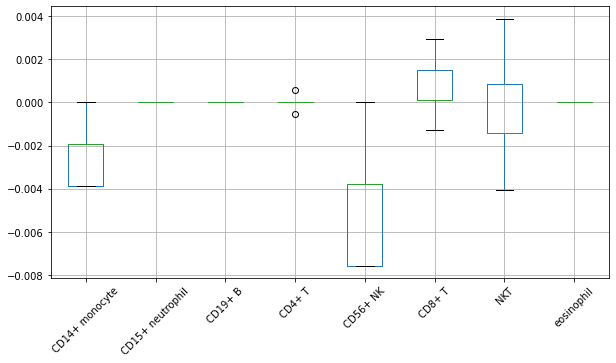

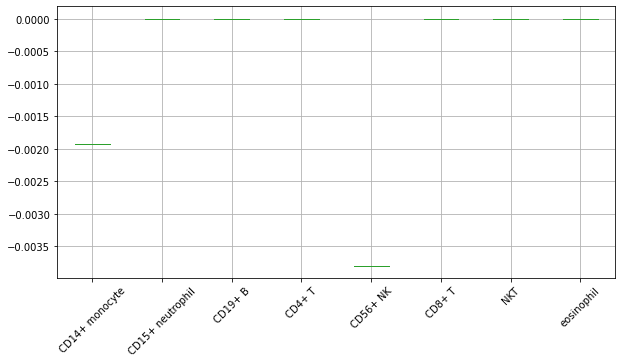

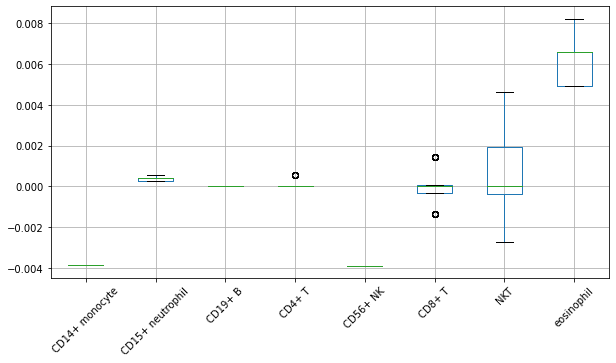

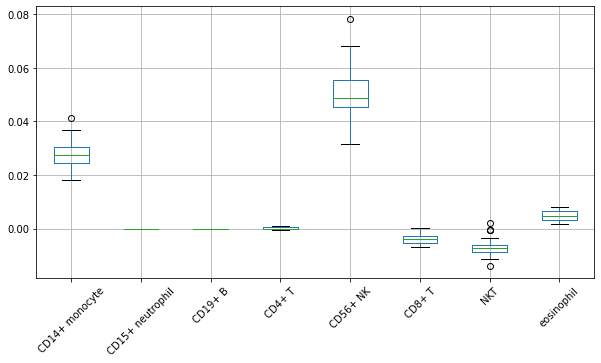

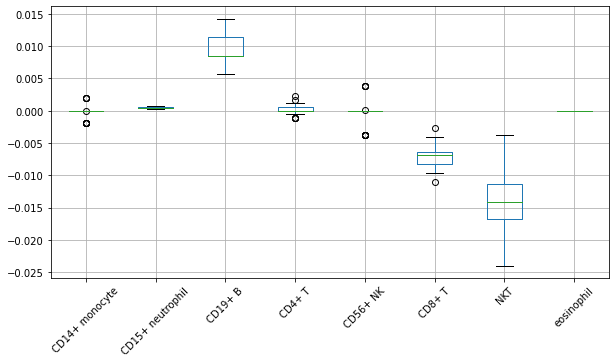

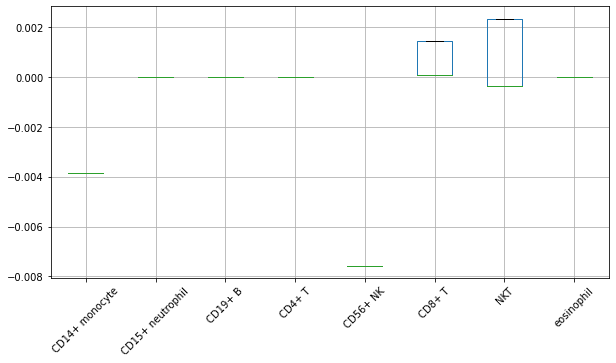

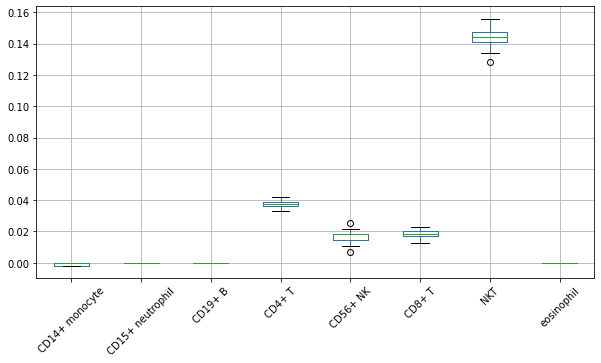

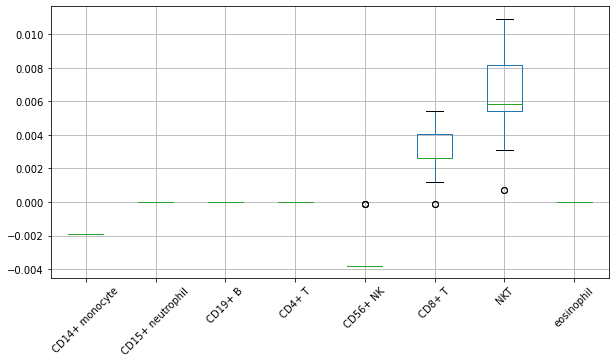

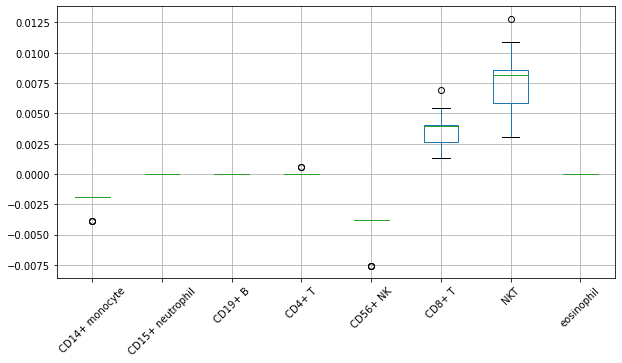

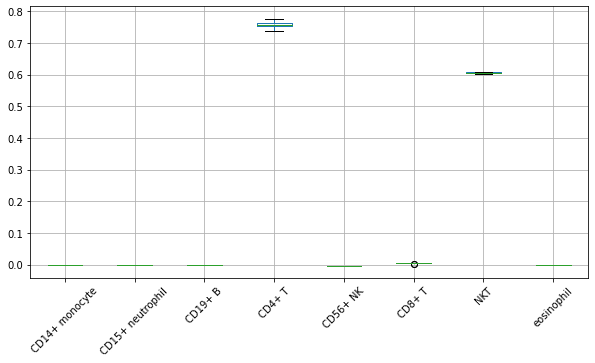

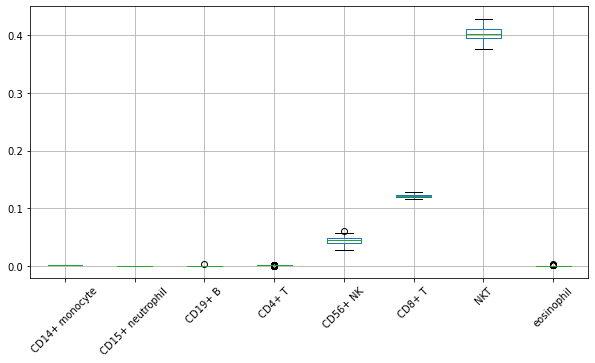

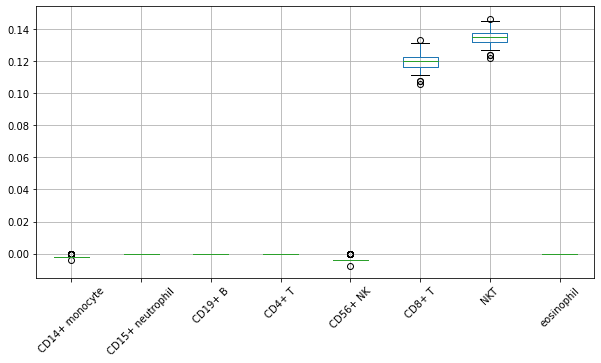

In [41]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in tqdm(range(shuffle_times)):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    #fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel  to remove is {}".format(candidate))

<BarContainer object of 12 artists>

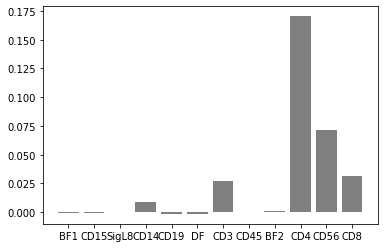

In [42]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
#plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [43]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [44]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [45]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    batch_size = 16
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    #plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

In [46]:
# DeepLift

Elapsed time: 4251.807669016 4233.707770017
Elapsed time during the whole program in seconds: 18.09989899899938


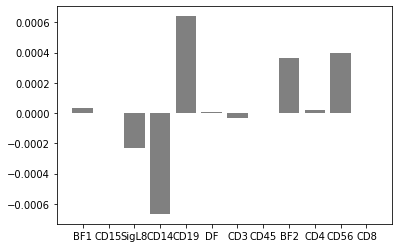

In [47]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')
dl = None
torch.cuda.empty_cache()

In [48]:
# Saliency

Elapsed time: 4267.883847882 4251.996810115
Elapsed time during the whole program in seconds: 15.887037767000038


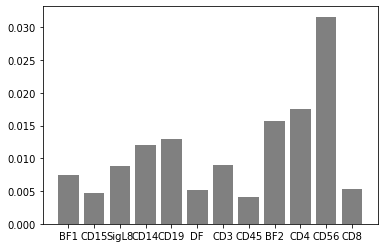

In [49]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')
saliency = None
torch.cuda.empty_cache()

In [50]:
# IntegratedGradients

Elapsed time: 4363.302617676 4268.06929816
Elapsed time during the whole program in seconds: 95.23331951600085


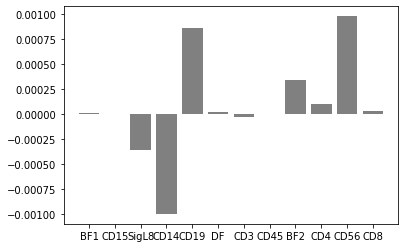

In [51]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')
ig = None
torch.cuda.empty_cache()

In [52]:
# LRP

Elapsed time: 4382.510697632 4363.538983482
Elapsed time during the whole program in seconds: 18.97171415000048


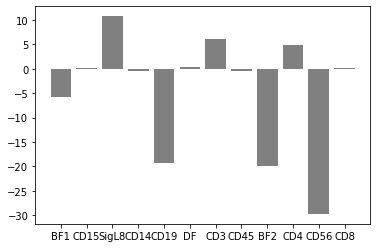

In [53]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')
lrp = None
torch.cuda.empty_cache()

In [54]:
# GuidedGradCAM

Elapsed time: 4403.139515013 4382.692068975
Elapsed time during the whole program in seconds: 20.447446037999725


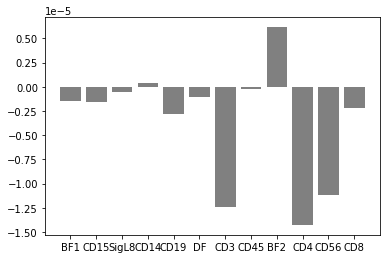

In [55]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')
guided_cram = None
torch.cuda.empty_cache()

In [56]:
channel_importance = pd.read_csv("channel_importance.csv")

channel_importance_fold = pd.DataFrame(columns = channel_importance.columns)

channel_importance_fold["channel"] = channels
channel_importance_fold["fold"] = main_fold
channel_importance_fold["PXPermute"] = channel_ranking_pixel_permutation["importance"]
channel_importance_fold["DeepLift"] = heatmaps_deeplift_mean.cpu().numpy()
channel_importance_fold["IntegratedGradients"] = heatmaps_integrated_gradient_mean.cpu().numpy()
channel_importance_fold["LRP"] = heatmaps_lrp_mean.cpu().numpy()
channel_importance_fold["GuidedGradCAM"] = heatmaps_gradcam_mean.cpu().numpy()

channel_importance = channel_importance.append(channel_importance_fold, ignore_index = True)

channel_importance.to_csv("channel_importance.csv", index = False)

5fold CV on the data and get the importance per fold for statistical evaluation
    
our result is in alignment with the original paper. On the other hand, guided gradcam failed

In [57]:
channel_importance

,fold,channel,PXPermute,DeepLift,LRP,GuidedGradCAM,IntegratedGradients
0,4,BF1,0.002034,1.605426e-03,-12.400846,-8.991536e-06,2.074527e-03
1,4,CD15,0.000439,6.993967e-06,-1.822934,-5.708454e-07,6.186348e-06
2,4,SigL8,0.001351,-7.963992e-05,-4.014456,5.194120e-06,-3.797350e-04
3,4,CD14,0.004518,-6.376401e-04,26.060090,8.728705e-06,-6.020912e-04
4,4,CD19,0.002529,9.043738e-05,-3.469203,-2.045696e-06,1.075690e-04
5,4,DF,0.000408,3.171338e-06,-0.689515,-2.486031e-06,2.249079e-06
6,4,CD3,0.033621,-1.425941e-04,-5.446074,-1.894273e-05,-2.290062e-04
7,4,CD45,0.001697,-2.354621e-05,0.477934,4.060209e-07,-2.032990e-05
8,4,BF2,0.001648,-1.655548e-03,19.235951,2.054818e-05,-1.797451e-03
9,4,CD4,0.053532,1.444129e-03,-16.101868,-4.654780e-05,1.718252e-03
